In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D

from keras import callbacks 
from keras.constraints import maxnorm
import keras
from sklearn.model_selection import KFold

In [2]:
#retrieve data
num = 2000 # number of profiles
nvza = 2 # number of channels
nsza=1

s = 82 # output slice size
ts = 82 # input slice size 

In [3]:
#get the averaged reflectance from the dataset 
r=np.load('monte_carlo_r.npy')
print(r.shape)
r=r.reshape((2000, 82, 2))
print(r.shape)

(2000, 82, 1, 2)
(2000, 82, 2)


In [4]:
#get the averaged reflectance from the dataset 
c=np.load('monte_carlo_cot.npy')
c.shape

(2000, 82)

In [5]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800
print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')





train_size: 1600 profiles
test_size: 400 profiles


In [6]:
import os
checkpoint_path = "training_lstm/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [10]:
#Bi-LSTM model-------------------------------------------------------------------------------------------------
def eval_model(train_image, test_image, train_label, test_label):
    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()

    bsize = 16
    eps = 4000

    input_layer = tf.keras.layers.Input(shape=(ts,2),name='Input')
    
    lstm=tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True,input_shape=(ts,2))(input_layer) 
    lstm=tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True)(lstm) 
    lstm=tf.keras.layers.LSTM(units=96, activation='tanh',return_sequences = True)(lstm) 
    flat=tf.keras.layers.Flatten()(lstm)

    output = tf.keras.layers.Dense(82,activation='relu')(flat)


    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

    model.summary()


    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 
    
    
     # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping,cp_callback])

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]

    return model,rmse,mse,history,predictions

In [11]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds) #800

X_train=np.zeros((5,400*4,ts,2))
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,ts,2))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index]
    y_train[count], y_test[count] = c[train_index], c[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 400  401  402 ... 1997 1998 1999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [12]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 82, 2)]           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 82, 64)            17152     
_________________________________________________________________
lstm_4 (LSTM)                (None, 82, 64)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 82, 96)            61824     
_________________________________________________________________
flatten_1 (Flatten)          (None, 7872)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 82)                645586    
Total params: 757,586
Trainable params: 757,586
Non-trainable params: 0
_____________________________________________________

75/75 [==============================] - 1s 16ms/step - loss: 6.7585 - mean_squared_error: 6.7585 - root_mean_squared_error: 2.5995 - val_loss: 9.3066 - val_mean_squared_error: 9.3066 - val_root_mean_squared_error: 3.0507

Epoch 00025: saving model to training_lstm\cp.ckpt
Epoch 26/4000
75/75 [==============================] - 1s 16ms/step - loss: 12.0581 - mean_squared_error: 12.0581 - root_mean_squared_error: 3.4638 - val_loss: 9.6988 - val_mean_squared_error: 9.6988 - val_root_mean_squared_error: 3.1143

Epoch 00026: saving model to training_lstm\cp.ckpt
Epoch 27/4000
75/75 [==============================] - 1s 16ms/step - loss: 6.9431 - mean_squared_error: 6.9431 - root_mean_squared_error: 2.6349 - val_loss: 9.0247 - val_mean_squared_error: 9.0247 - val_root_mean_squared_error: 3.0041

Epoch 00027: saving model to training_lstm\cp.ckpt
Epoch 28/4000
75/75 [==============================] - 1s 15ms/step - loss: 6.2963 - mean_squared_error: 6.2963 - root_mean_squared_error: 2.5092 - 


Epoch 00053: saving model to training_lstm\cp.ckpt
Epoch 54/4000
75/75 [==============================] - 1s 16ms/step - loss: 2.2608 - mean_squared_error: 2.2608 - root_mean_squared_error: 1.5035 - val_loss: 7.3700 - val_mean_squared_error: 7.3700 - val_root_mean_squared_error: 2.7148

Epoch 00054: saving model to training_lstm\cp.ckpt
Epoch 55/4000
75/75 [==============================] - 1s 16ms/step - loss: 2.1614 - mean_squared_error: 2.1614 - root_mean_squared_error: 1.4701 - val_loss: 7.3661 - val_mean_squared_error: 7.3661 - val_root_mean_squared_error: 2.7140

Epoch 00055: saving model to training_lstm\cp.ckpt
Epoch 56/4000
75/75 [==============================] - 1s 16ms/step - loss: 2.0275 - mean_squared_error: 2.0275 - root_mean_squared_error: 1.4237 - val_loss: 7.4433 - val_mean_squared_error: 7.4433 - val_root_mean_squared_error: 2.7282

Epoch 00056: saving model to training_lstm\cp.ckpt
Epoch 57/4000
75/75 [==============================] - 1s 16ms/step - loss: 1.9693 -

75/75 [==============================] - 1s 16ms/step - loss: 0.6196 - mean_squared_error: 0.6196 - root_mean_squared_error: 0.7865 - val_loss: 7.7308 - val_mean_squared_error: 7.7308 - val_root_mean_squared_error: 2.7804

Epoch 00082: saving model to training_lstm\cp.ckpt
Epoch 83/4000
75/75 [==============================] - 1s 18ms/step - loss: 0.6178 - mean_squared_error: 0.6178 - root_mean_squared_error: 0.7859 - val_loss: 7.7743 - val_mean_squared_error: 7.7743 - val_root_mean_squared_error: 2.7882

Epoch 00083: saving model to training_lstm\cp.ckpt
Epoch 84/4000
75/75 [==============================] - 1s 17ms/step - loss: 0.5612 - mean_squared_error: 0.5612 - root_mean_squared_error: 0.7491 - val_loss: 7.8514 - val_mean_squared_error: 7.8514 - val_root_mean_squared_error: 2.8020
Restoring model weights from the end of the best epoch.

Epoch 00084: saving model to training_lstm\cp.ckpt
Epoch 00084: early stopping
test result
13/13 [==============================] - 1s 8ms/step -

75/75 [==============================] - 1s 15ms/step - loss: 8.0112 - mean_squared_error: 8.0112 - root_mean_squared_error: 2.8303 - val_loss: 9.9785 - val_mean_squared_error: 9.9785 - val_root_mean_squared_error: 3.1589

Epoch 00021: saving model to training_lstm\cp.ckpt
Epoch 22/4000
75/75 [==============================] - 1s 16ms/step - loss: 7.2753 - mean_squared_error: 7.2753 - root_mean_squared_error: 2.6971 - val_loss: 9.5784 - val_mean_squared_error: 9.5784 - val_root_mean_squared_error: 3.0949

Epoch 00022: saving model to training_lstm\cp.ckpt
Epoch 23/4000
75/75 [==============================] - 1s 16ms/step - loss: 7.2619 - mean_squared_error: 7.2619 - root_mean_squared_error: 2.6946 - val_loss: 9.5111 - val_mean_squared_error: 9.5111 - val_root_mean_squared_error: 3.0840

Epoch 00023: saving model to training_lstm\cp.ckpt
Epoch 24/4000
75/75 [==============================] - 1s 16ms/step - loss: 6.9007 - mean_squared_error: 6.9007 - root_mean_squared_error: 2.6268 - va


Epoch 00049: saving model to training_lstm\cp.ckpt
Epoch 50/4000
75/75 [==============================] - 1s 18ms/step - loss: 2.2021 - mean_squared_error: 2.2021 - root_mean_squared_error: 1.4839 - val_loss: 7.1912 - val_mean_squared_error: 7.1912 - val_root_mean_squared_error: 2.6816

Epoch 00050: saving model to training_lstm\cp.ckpt
Epoch 51/4000
75/75 [==============================] - 1s 17ms/step - loss: 2.0736 - mean_squared_error: 2.0736 - root_mean_squared_error: 1.4398 - val_loss: 7.1995 - val_mean_squared_error: 7.1995 - val_root_mean_squared_error: 2.6832

Epoch 00051: saving model to training_lstm\cp.ckpt
Epoch 52/4000
75/75 [==============================] - 1s 16ms/step - loss: 1.9619 - mean_squared_error: 1.9619 - root_mean_squared_error: 1.4006 - val_loss: 7.1631 - val_mean_squared_error: 7.1631 - val_root_mean_squared_error: 2.6764

Epoch 00052: saving model to training_lstm\cp.ckpt
Epoch 53/4000
75/75 [==============================] - 1s 17ms/step - loss: 1.8248 -

75/75 [==============================] - 7s 35ms/step - loss: 145.0268 - mean_squared_error: 145.0268 - root_mean_squared_error: 12.0002 - val_loss: 88.2340 - val_mean_squared_error: 88.2340 - val_root_mean_squared_error: 9.3933

Epoch 00001: saving model to training_lstm\cp.ckpt
Epoch 2/4000
75/75 [==============================] - 1s 19ms/step - loss: 71.7474 - mean_squared_error: 71.7474 - root_mean_squared_error: 8.4532 - val_loss: 47.2935 - val_mean_squared_error: 47.2935 - val_root_mean_squared_error: 6.8770

Epoch 00002: saving model to training_lstm\cp.ckpt
Epoch 3/4000
75/75 [==============================] - 1s 16ms/step - loss: 44.8584 - mean_squared_error: 44.8584 - root_mean_squared_error: 6.6965 - val_loss: 38.9695 - val_mean_squared_error: 38.9695 - val_root_mean_squared_error: 6.2426

Epoch 00003: saving model to training_lstm\cp.ckpt
Epoch 4/4000
75/75 [==============================] - 1s 16ms/step - loss: 37.4476 - mean_squared_error: 37.4476 - root_mean_squared_erro

75/75 [==============================] - 1s 16ms/step - loss: 5.6814 - mean_squared_error: 5.6814 - root_mean_squared_error: 2.3835 - val_loss: 8.5931 - val_mean_squared_error: 8.5931 - val_root_mean_squared_error: 2.9314

Epoch 00029: saving model to training_lstm\cp.ckpt
Epoch 30/4000
75/75 [==============================] - 1s 17ms/step - loss: 5.5059 - mean_squared_error: 5.5059 - root_mean_squared_error: 2.3463 - val_loss: 8.4130 - val_mean_squared_error: 8.4130 - val_root_mean_squared_error: 2.9005

Epoch 00030: saving model to training_lstm\cp.ckpt
Epoch 31/4000
75/75 [==============================] - 1s 17ms/step - loss: 5.3193 - mean_squared_error: 5.3193 - root_mean_squared_error: 2.3062 - val_loss: 8.3061 - val_mean_squared_error: 8.3061 - val_root_mean_squared_error: 2.8820

Epoch 00031: saving model to training_lstm\cp.ckpt
Epoch 32/4000
75/75 [==============================] - 1s 18ms/step - loss: 5.1835 - mean_squared_error: 5.1835 - root_mean_squared_error: 2.2767 - va


Epoch 00057: saving model to training_lstm\cp.ckpt
Epoch 58/4000
75/75 [==============================] - 1s 17ms/step - loss: 1.6739 - mean_squared_error: 1.6739 - root_mean_squared_error: 1.2937 - val_loss: 7.2409 - val_mean_squared_error: 7.2409 - val_root_mean_squared_error: 2.6909

Epoch 00058: saving model to training_lstm\cp.ckpt
Epoch 59/4000
75/75 [==============================] - 1s 17ms/step - loss: 1.6118 - mean_squared_error: 1.6118 - root_mean_squared_error: 1.2695 - val_loss: 7.2292 - val_mean_squared_error: 7.2292 - val_root_mean_squared_error: 2.6887

Epoch 00059: saving model to training_lstm\cp.ckpt
Epoch 60/4000
75/75 [==============================] - 1s 17ms/step - loss: 1.5087 - mean_squared_error: 1.5087 - root_mean_squared_error: 1.2280 - val_loss: 7.3818 - val_mean_squared_error: 7.3818 - val_root_mean_squared_error: 2.7169

Epoch 00060: saving model to training_lstm\cp.ckpt
Epoch 61/4000
75/75 [==============================] - 1s 18ms/step - loss: 1.4789 -

75/75 [==============================] - 7s 29ms/step - loss: 150.2875 - mean_squared_error: 150.2875 - root_mean_squared_error: 12.2244 - val_loss: 97.1843 - val_mean_squared_error: 97.1843 - val_root_mean_squared_error: 9.8582

Epoch 00001: saving model to training_lstm\cp.ckpt
Epoch 2/4000
75/75 [==============================] - 1s 16ms/step - loss: 79.3879 - mean_squared_error: 79.3879 - root_mean_squared_error: 8.8955 - val_loss: 49.2812 - val_mean_squared_error: 49.2812 - val_root_mean_squared_error: 7.0201

Epoch 00002: saving model to training_lstm\cp.ckpt
Epoch 3/4000
75/75 [==============================] - 1s 16ms/step - loss: 45.9269 - mean_squared_error: 45.9269 - root_mean_squared_error: 6.7763 - val_loss: 37.5458 - val_mean_squared_error: 37.5458 - val_root_mean_squared_error: 6.1275

Epoch 00003: saving model to training_lstm\cp.ckpt
Epoch 4/4000
75/75 [==============================] - 1s 17ms/step - loss: 34.8608 - mean_squared_error: 34.8608 - root_mean_squared_erro

75/75 [==============================] - 1s 16ms/step - loss: 6.0911 - mean_squared_error: 6.0911 - root_mean_squared_error: 2.4678 - val_loss: 8.7833 - val_mean_squared_error: 8.7833 - val_root_mean_squared_error: 2.9637

Epoch 00029: saving model to training_lstm\cp.ckpt
Epoch 30/4000
75/75 [==============================] - 1s 18ms/step - loss: 5.8934 - mean_squared_error: 5.8934 - root_mean_squared_error: 2.4276 - val_loss: 8.6985 - val_mean_squared_error: 8.6985 - val_root_mean_squared_error: 2.9493

Epoch 00030: saving model to training_lstm\cp.ckpt
Epoch 31/4000
75/75 [==============================] - 1s 17ms/step - loss: 5.6094 - mean_squared_error: 5.6094 - root_mean_squared_error: 2.3683 - val_loss: 8.4758 - val_mean_squared_error: 8.4758 - val_root_mean_squared_error: 2.9113

Epoch 00031: saving model to training_lstm\cp.ckpt
Epoch 32/4000
75/75 [==============================] - 1s 16ms/step - loss: 5.4640 - mean_squared_error: 5.4640 - root_mean_squared_error: 2.3374 - va


Epoch 00057: saving model to training_lstm\cp.ckpt
Epoch 58/4000
75/75 [==============================] - 1s 17ms/step - loss: 2.0109 - mean_squared_error: 2.0109 - root_mean_squared_error: 1.4180 - val_loss: 7.0410 - val_mean_squared_error: 7.0410 - val_root_mean_squared_error: 2.6535

Epoch 00058: saving model to training_lstm\cp.ckpt
Epoch 59/4000
75/75 [==============================] - 1s 17ms/step - loss: 1.8166 - mean_squared_error: 1.8166 - root_mean_squared_error: 1.3476 - val_loss: 7.0457 - val_mean_squared_error: 7.0457 - val_root_mean_squared_error: 2.6544

Epoch 00059: saving model to training_lstm\cp.ckpt
Epoch 60/4000
75/75 [==============================] - 1s 16ms/step - loss: 1.7970 - mean_squared_error: 1.7970 - root_mean_squared_error: 1.3404 - val_loss: 6.9945 - val_mean_squared_error: 6.9945 - val_root_mean_squared_error: 2.6447

Epoch 00060: saving model to training_lstm\cp.ckpt
Epoch 61/4000
75/75 [==============================] - 1s 15ms/step - loss: 1.6302 -

75/75 [==============================] - 1s 17ms/step - loss: 84.9104 - mean_squared_error: 84.9104 - root_mean_squared_error: 9.2005 - val_loss: 44.7415 - val_mean_squared_error: 44.7415 - val_root_mean_squared_error: 6.6889

Epoch 00002: saving model to training_lstm\cp.ckpt
Epoch 3/4000
75/75 [==============================] - 1s 17ms/step - loss: 40.6813 - mean_squared_error: 40.6813 - root_mean_squared_error: 6.3769 - val_loss: 33.2372 - val_mean_squared_error: 33.2372 - val_root_mean_squared_error: 5.7652

Epoch 00003: saving model to training_lstm\cp.ckpt
Epoch 4/4000
75/75 [==============================] - 1s 17ms/step - loss: 32.3894 - mean_squared_error: 32.3894 - root_mean_squared_error: 5.6910 - val_loss: 28.6374 - val_mean_squared_error: 28.6374 - val_root_mean_squared_error: 5.3514

Epoch 00004: saving model to training_lstm\cp.ckpt
Epoch 5/4000
75/75 [==============================] - 1s 16ms/step - loss: 26.4976 - mean_squared_error: 26.4976 - root_mean_squared_error: 

75/75 [==============================] - 1s 18ms/step - loss: 5.6324 - mean_squared_error: 5.6324 - root_mean_squared_error: 2.3732 - val_loss: 8.1540 - val_mean_squared_error: 8.1540 - val_root_mean_squared_error: 2.8555

Epoch 00030: saving model to training_lstm\cp.ckpt
Epoch 31/4000
75/75 [==============================] - 1s 16ms/step - loss: 5.3715 - mean_squared_error: 5.3715 - root_mean_squared_error: 2.3176 - val_loss: 8.0846 - val_mean_squared_error: 8.0846 - val_root_mean_squared_error: 2.8433

Epoch 00031: saving model to training_lstm\cp.ckpt
Epoch 32/4000
75/75 [==============================] - 1s 16ms/step - loss: 5.1276 - mean_squared_error: 5.1276 - root_mean_squared_error: 2.2642 - val_loss: 8.1714 - val_mean_squared_error: 8.1714 - val_root_mean_squared_error: 2.8586

Epoch 00032: saving model to training_lstm\cp.ckpt
Epoch 33/4000
75/75 [==============================] - 1s 18ms/step - loss: 4.9497 - mean_squared_error: 4.9497 - root_mean_squared_error: 2.2247 - va


Epoch 00058: saving model to training_lstm\cp.ckpt
Epoch 59/4000
75/75 [==============================] - 1s 16ms/step - loss: 1.7760 - mean_squared_error: 1.7760 - root_mean_squared_error: 1.3326 - val_loss: 7.1561 - val_mean_squared_error: 7.1561 - val_root_mean_squared_error: 2.6751

Epoch 00059: saving model to training_lstm\cp.ckpt
Epoch 60/4000
75/75 [==============================] - 1s 16ms/step - loss: 1.6824 - mean_squared_error: 1.6824 - root_mean_squared_error: 1.2970 - val_loss: 7.2837 - val_mean_squared_error: 7.2837 - val_root_mean_squared_error: 2.6988

Epoch 00060: saving model to training_lstm\cp.ckpt
Epoch 61/4000
75/75 [==============================] - 1s 15ms/step - loss: 1.5971 - mean_squared_error: 1.5971 - root_mean_squared_error: 1.2637 - val_loss: 7.2803 - val_mean_squared_error: 7.2803 - val_root_mean_squared_error: 2.6982

Epoch 00061: saving model to training_lstm\cp.ckpt
Epoch 62/4000
75/75 [==============================] - 1s 16ms/step - loss: 1.6302 -

In [13]:
#quantitative result
print(' Test MSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print(' Test RMSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

 Test MSE 6.9347 with standard devisation (0.3286)
 Test RMSE 2.6327 with standard devisation (0.0618)


In [14]:
predictions.shape

(400, 82)

In [15]:
cv_scores #MSE

[7.0811238288879395,
 6.739037036895752,
 6.708563804626465,
 6.630375385284424,
 7.514646053314209]

In [16]:
cv_scores2 #RMSE

[2.6610379219055176,
 2.595965623855591,
 2.5900895595550537,
 2.574951648712158,
 2.741285562515259]

The optimal number of epochs is 54


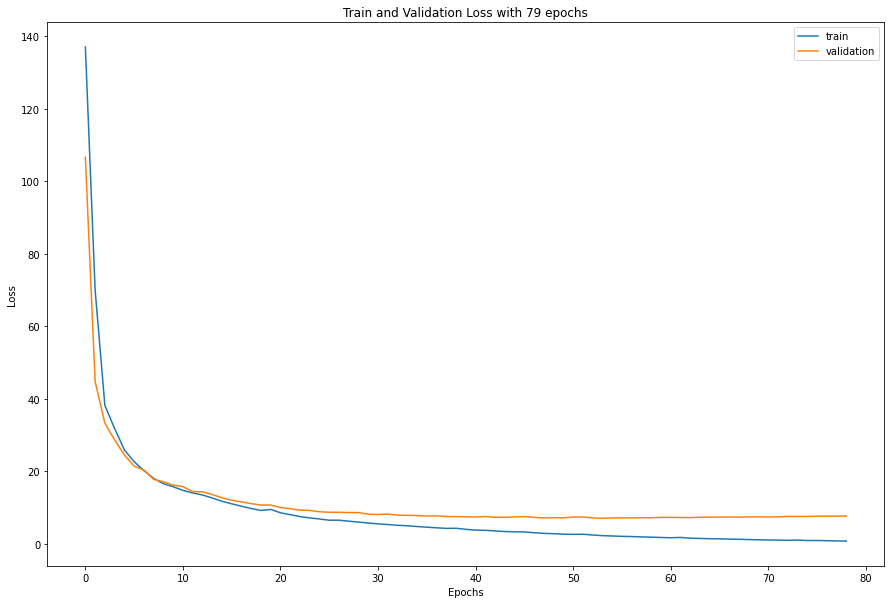

In [17]:
patience=25
# plot training and validation history
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [18]:
predict1=np.zeros((82)) #82
predict1=predictions[-3]
    
predict2=np.zeros((82))
predict2=predictions[-2]
    
predict3=np.zeros((82))
predict3=predictions[-1]

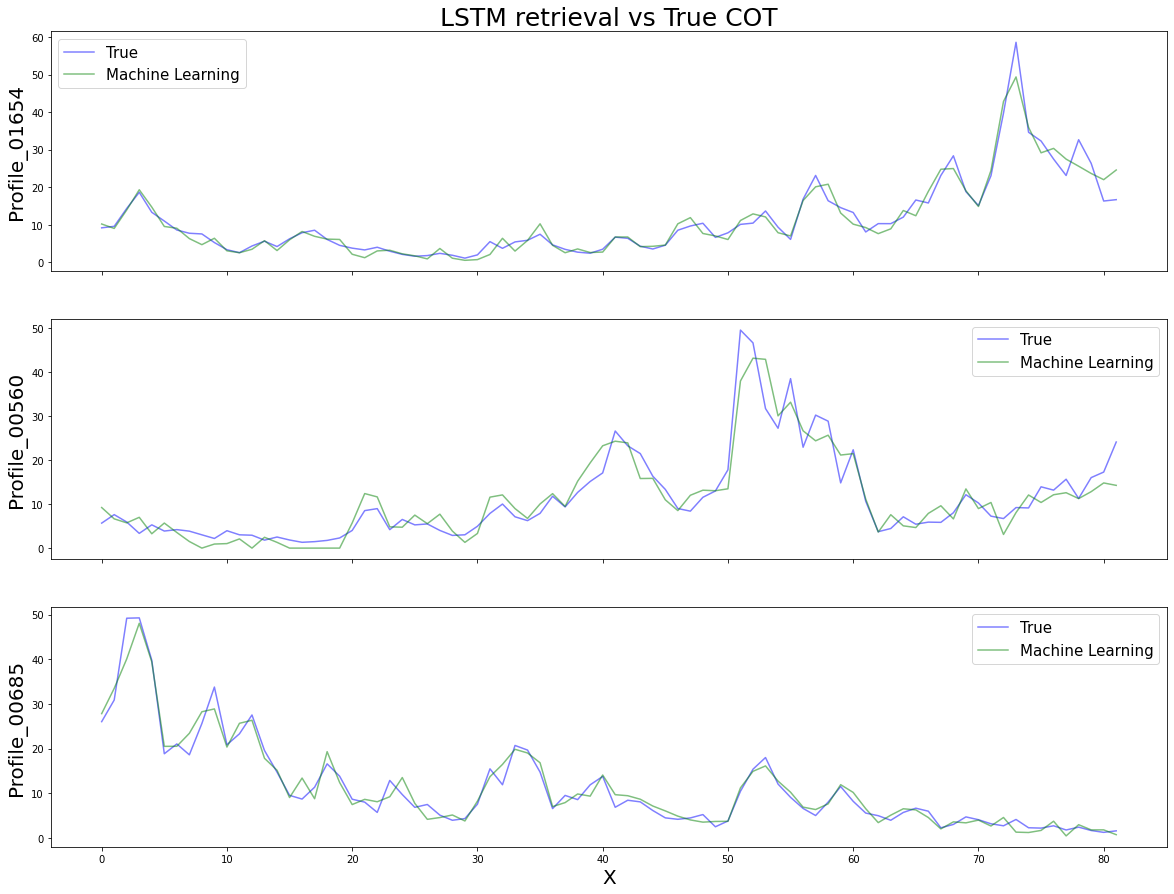

In [21]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/LSTM "+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"LSTM retrieval vs True COT", fontsize=25)
ax.plot(range(82),c[num-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_00560",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1].T,alpha=0.5,color="blue")
ax.plot(range(82),predict3,alpha=0.5,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_00685",fontsize=20)  
ax.set_xlabel('X', fontsize=20)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

# Plotting across predicted 82 COT values

In [26]:
std=[]
mean=[]

for k in range(82):
    tmp=[]
    for j in range(test_size):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))

    std.append(np.std(tmp))
    mean.append(np.mean(tmp))
std=np.array(std)
mean=np.array(mean)
std1 = np.std(mean) #standard deviation of the mean absolute difference across the 82 cot values 


In [27]:
len(mean)

82

In [28]:
len(std)

82

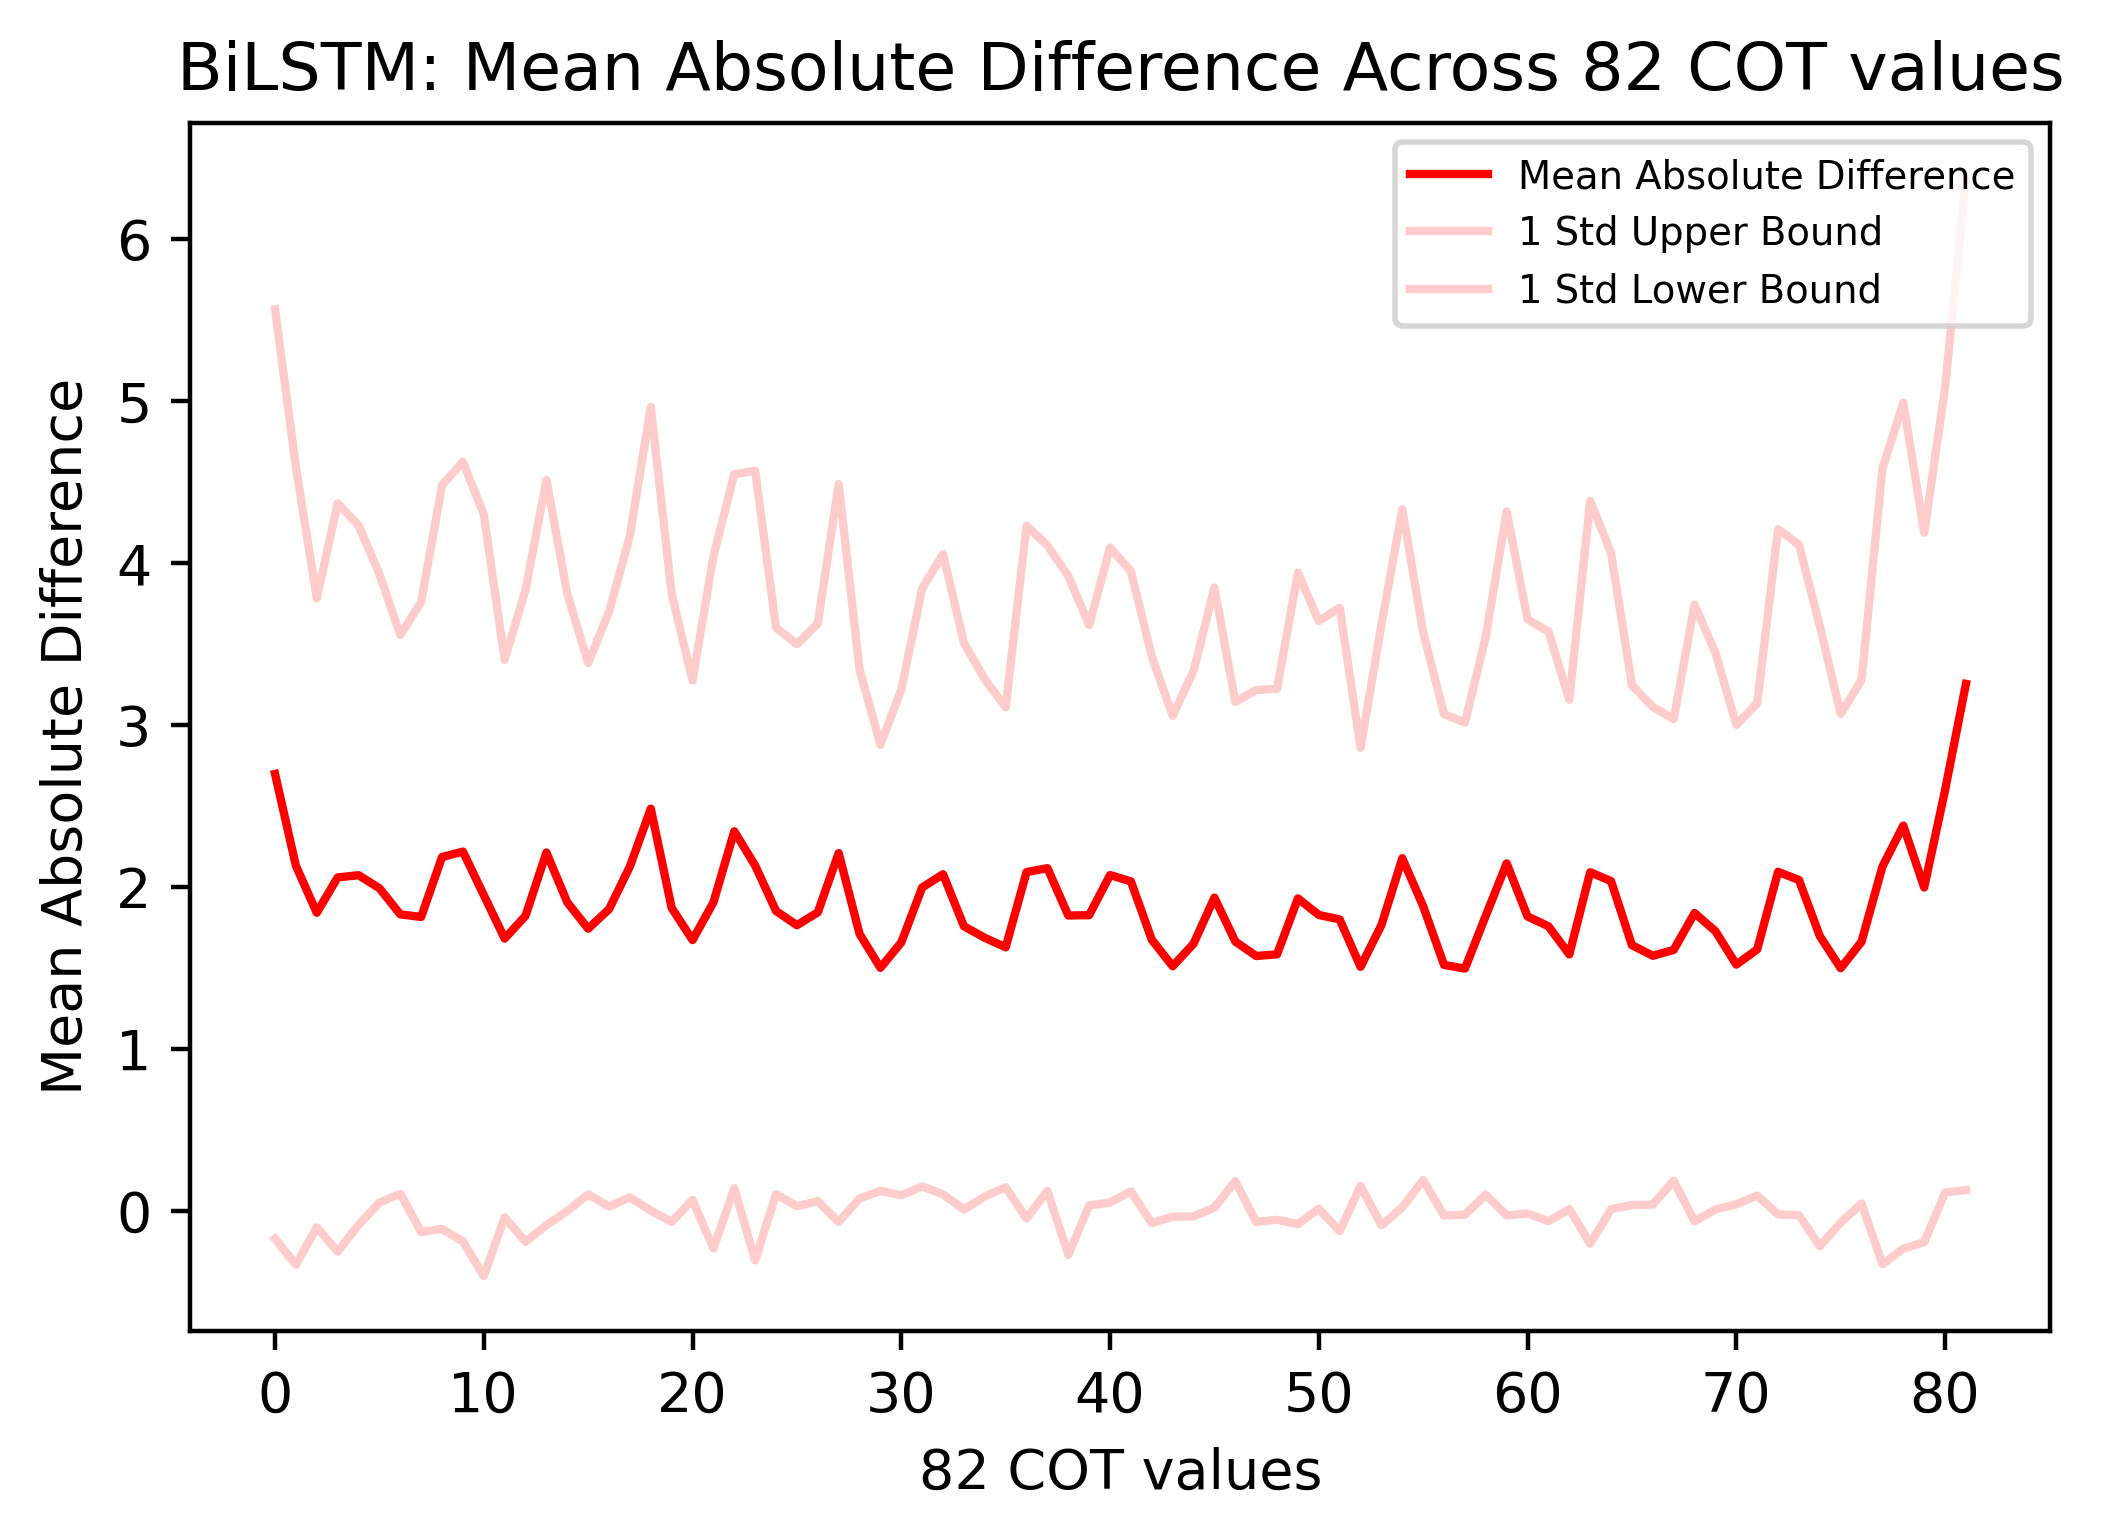

In [29]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/v1-BiLSTM_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

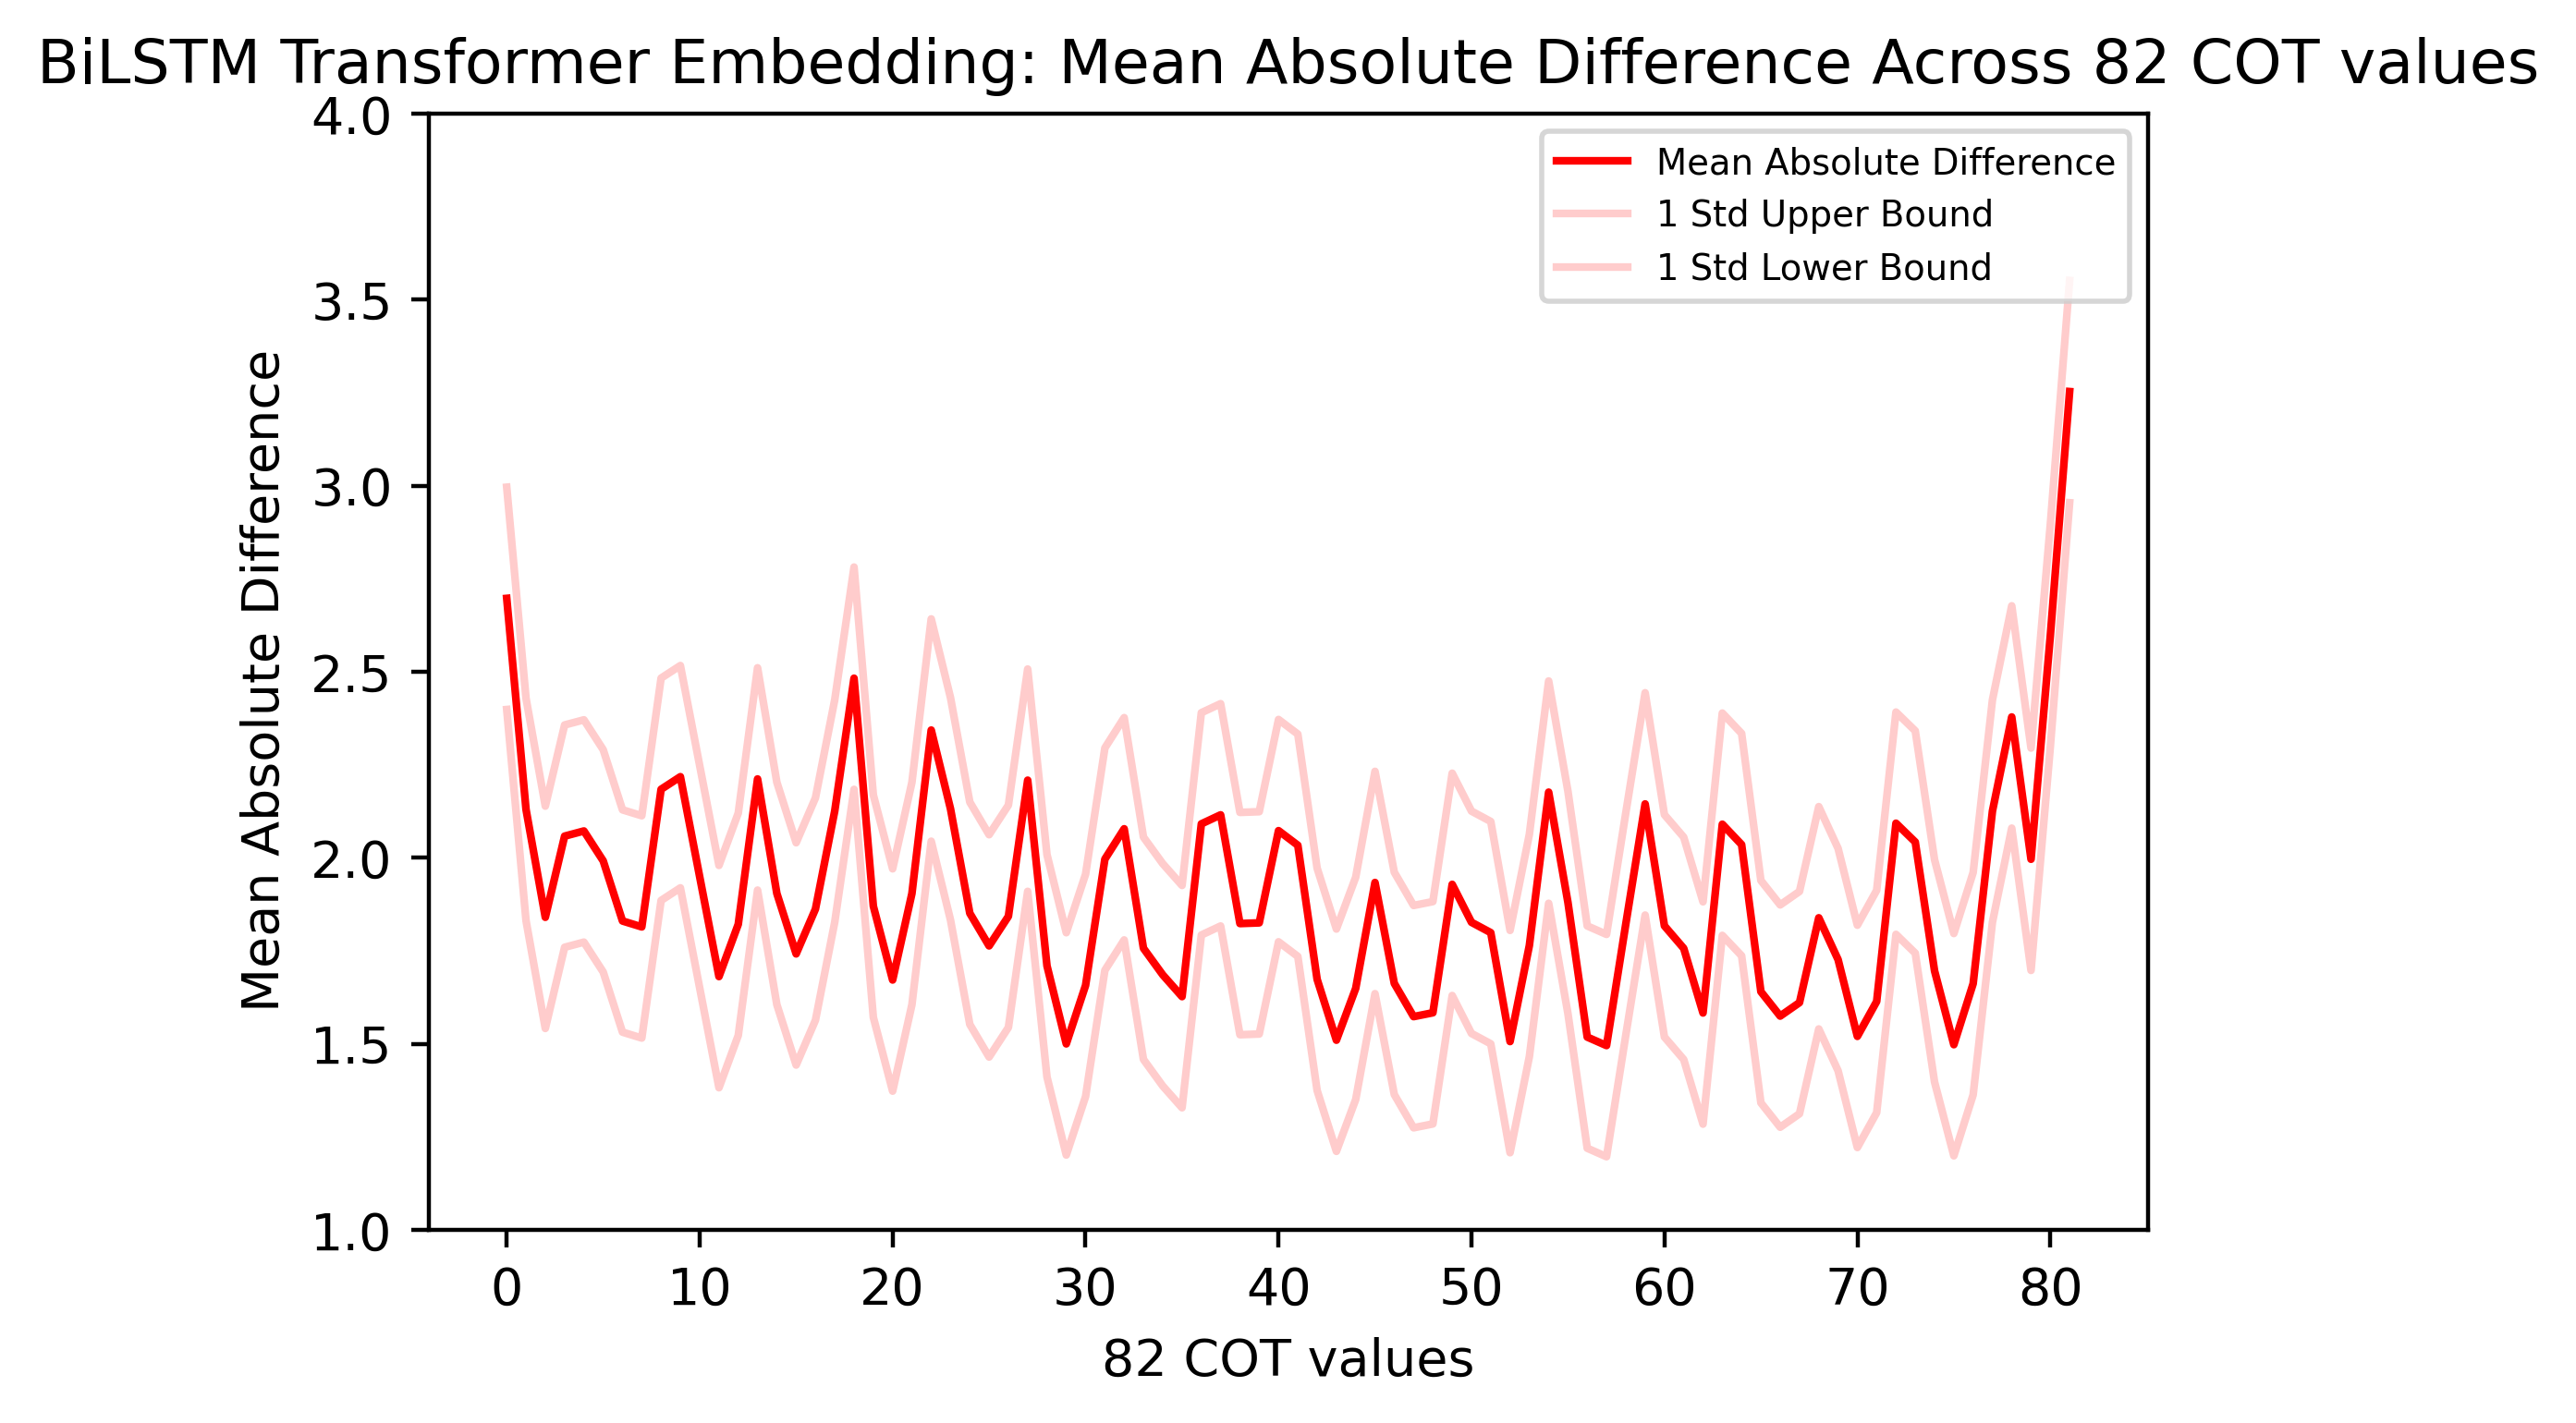

In [33]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std1, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std1, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylim((1,4))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/LSTM_with_ Transformer_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)